In [1]:
import pandas as pd
import numpy as np
import requests
import json
from pandas import json_normalize
from requests.auth import HTTPBasicAuth

from dotenv.main import load_dotenv
import os

from fuzzywuzzy import process
from fuzzywuzzy import fuzz

import seaborn as sns

from sklearn.preprocessing import LabelEncoder

import nltk
from nltk.tokenize import word_tokenize

import math


pd.options.display.max_seq_items = 20000
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 2000)

In [2]:
#Load the Api Key

from dotenv.main import load_dotenv
import os
load_dotenv()
API_KEY=os.environ["api_key"]

### 0.1 Notes and Thoughts

Hard Filters that are needed for the Dataset are:
- B2C
- Europe 
- (Later industry, first iteration without industry specificat)

All Available fields:
id
name
type
deleted
path
tagline
about
url,website_url,twitter_url,facebook_url,linkedin_url,google_url,crunchbase_url,angellist_url
playmarket_app_id,appstore_app_id
images
employees,employees_latest
industries,sub_industries,corporate_industries,service_industries
technologies
income_streams
growth_stage
traffic_summary
hq_locations
client_focus
revenues
tags
ownerships
delivery_method
launch_year,launch_month
has_promising_founder,has_strong_founder,has_super_founder
total_funding,total_funding_source,last_funding,last_funding_source
company_status,last_updated,last_updated_utc,created_utc
facebook_likes_chart,twitter_tweets_chart,twitter_followers_chart,twitter_favorites_chart
employees_chart
similarweb_3_months_growth_unique,similarweb_3_months_growth_percentile,similarweb_3_months_growth_relative,similarweb_3_months_growth_delta,similarweb_6_months_growth_unique,similarweb_6_months_growth_percentile,similarweb_6_months_growth_relative,similarweb_6_months_growth_delta,similarweb_12_months_growth_unique,similarweb_12_months_growth_percentile,similarweb_12_months_growth_relative,similarweb_12_months_growth_delta

app_3_months_growth_unique,app_3_months_growth_percentile,app_3_months_growth_relative,app_6_months_growth_unique,app_6_months_growth_percentile,app_6_months_growth_relative,app_12_months_growth_unique,app_12_months_growth_percentile,app_12_months_growth_relative,employee_3_months_growth_unique

employee_3_months_growth_percentile,employee_3_months_growth_relative,employee_3_months_growth_delta,employee_6_months_growth_unique,employee_6_months_growth_percentile,employee_6_months_growth_relative,employee_6_months_growth_delta,employee_12_months_growth_unique,employee_12_months_growth_percentile,employee_12_months_growth_relative,employee_12_months_growth_delta
kpi_summary
team
investors
fundings
traffic
similarweb_chart
job_openings
exits
trading_multiple
app_downloads_ios_chart,app_downloads_android_chart,app_downloads_ios_incremental_chart,app_downloads_android_incremental_chart
tech_stack_predictleads
sustainable_development_goals
core_side_value
data_type
pic_number
patents_count


### 0.2 Getting Available Filters for the Post Requests

In [289]:

api_url="https://api.dealroom.co/api/v1/companies/filters"
auth=HTTPBasicAuth(API_KEY, '')

headers = {'Content-Type': 'application/json'}
data={"fields":"launch_year",
              "limit": 1,
              "offset": 0
             }
response = requests.post(api_url,data=json.dumps(data),auth=auth,headers=headers)
data=response.json()
data


{'items': [{'key': 'launch_year',
   'items': [{'name': 2015, 'count': 84335, 'active': False},
    {'name': 2016, 'count': 79793, 'active': False},
    {'name': 2014, 'count': 77962, 'active': False},
    {'name': 2017, 'count': 76836, 'active': False},
    {'name': 2018, 'count': 72570, 'active': False},
    {'name': 2013, 'count': 72278, 'active': False},
    {'name': 2019, 'count': 69834, 'active': False},
    {'name': 2012, 'count': 68595, 'active': False},
    {'name': 2020, 'count': 62083, 'active': False},
    {'name': 2011, 'count': 58551, 'active': False},
    {'name': 2010, 'count': 55704, 'active': False},
    {'name': 2009, 'count': 46991, 'active': False},
    {'name': 2008, 'count': 40860, 'active': False},
    {'name': 2007, 'count': 37910, 'active': False},
    {'name': 2021, 'count': 37737, 'active': False},
    {'name': 2006, 'count': 33847, 'active': False},
    {'name': 2005, 'count': 30030, 'active': False},
    {'name': 2004, 'count': 27234, 'active': False},
   

# 1.1 Building the Core DF

1. Variables for the DF:

1.1: Independent Variables
- Team
- patents (patents_count)
- Round (fundings)
- Investors
- employees (latest, chart)
- Num. Investors (investors)
- (Industry Category) (industries)
- Description Length (about)
- Has Domain (website_url)
- Has Facebook (facebook_url)
- Has Twitter (twitter_url)
- Has LinkedIn (linkedin_url)
- Geographical Region (country, city/-code) (hq_locations)
- Total Funding (total_funding) (in mio)

1.2 Dependent Variables:
- Stage


Goal:
Predict possibility of follow on funding within the time frame of 3 years
Alternative: Predict possibility of funding, fail, acquisition, public

Rows that are dropped with empty values in following columns:
1. Web Url 
    avoid ghost companies
2. ownerships 
    bootstraped companies will not have funding information, thus not a missing value
    also essential for dependend variable
3. company status
    little info missing
4. launch year
    essential to project data to past
5. team items
    Intuitively most essential for predictive power

Open Questions:
- Should there be a difference between companies that are bootstrapped and dont want a funding or companies that are bootstrapped and dont get one
    - the later should realise through company failing

### Importing the Json file through according API Call:

In [290]:
fields="id,name,about,tagline,investors,industries,website_url,facebook_url,twitter_url,linkedin_url,hq_locations,total_funding,company_status,ownerships,team,fundings,patents_count,employees_latest,employees_chart,launch_year,dealroom_signal"
api_url="https://api.dealroom.co/api/v1/companies/bulk"
auth=HTTPBasicAuth(API_KEY, '')
headers = {'Content-Type': 'application/json'}

json_list=[]
next_page_id = ''
k=0

while True:
    data = {
        'form_data': {'must':{'hq_locations': ['Europe'], 'client_focus':['business']}},
        'fields': fields,
        'next_page_id': next_page_id,
        'limit': 100,
        }

    headers = {'Content-Type': 'application/json'}

    response = requests.post(api_url,data=json.dumps(data),auth=auth,headers=headers)

    res=json.loads(response.text)
    json_list.append(res)
    k+=1
    if (k/10).is_integer():
        print(k,end="\r")
    next_page_id = res['next_page_id']

    if next_page_id == None:
        break

In [291]:
with open("first_json.json", "w") as fp:
        json.dump(json_list, fp)

In [25]:
f=open("/Users/klaus/Documents/Jarvis/Second Try/Data/first_json.json")
json_list=json.load(f)

### 1.2 Converting Json to Pandas DF

In [292]:
df_list=[]
for i in range(len(json_list)):
    df_1=pd.json_normalize(json_list[i]["items"],sep="_").drop(columns=["hq_locations","industries"])
    df_1[["country_name","city_name"]]=pd.json_normalize(json_list[0]["items"],"hq_locations")[["country.name","city.name"]]
    df_1["industry_name"]=pd.json_normalize(json_list[0]["items"],"industries")["name"]
    df_list.append(df_1)

In [293]:
df=pd.concat(df_list)

In [294]:
df.shape

(222192, 25)

## 1.3 DataCleaning

In [295]:
x=df.isna().sum()
y=df.isna().sum()/len(df)*100
missing_values=pd.concat([x, y], axis=1)
missing_values.columns=["Missing Values","In percent"]
print(missing_values)


                  Missing Values  In percent
id                             0    0.000000
name                           0    0.000000
about                      57595   25.921275
tagline                    63302   28.489775
website_url                  616    0.277238
facebook_url              175755   79.100508
twitter_url               112862   50.794808
linkedin_url               50588   22.767696
total_funding                  0    0.000000
company_status                84    0.037805
ownerships                     0    0.000000
patents_count                  0    0.000000
employees_latest           59830   26.927162
employees_chart                0    0.000000
launch_year                34707   15.620274
dealroom_signal           177722   79.985778
investors_items                0    0.000000
investors_total                0    0.000000
team_items                     0    0.000000
team_total                     0    0.000000
fundings_items                 0    0.000000
fundings_t

In [296]:
df.dropna(subset=["website_url"],inplace=True) #companies without website will be deleted to avoid ghost companies
df.dropna(subset=["company_status"],inplace=True)
df.dropna(subset=["launch_year"],inplace=True)#companies without status (only 85 so can be dismissed)

### Number of Empty lists as entries

In [299]:
for i,row in missing_values.iterrows():
    try:
        print(i,df[i].apply(lambda x:1 if len(x) == 0 else 0).sum()/len(df)*100,"%")
    except:
        None



name 0.0 %
website_url 0.0 %
company_status 0.0 %
ownerships 52.72182863253576 %
employees_chart 20.076995054137146 %
investors_items 72.37588557679454 %
team_items 56.14971260526668 %
fundings_items 72.35931025264001 %
country_name 0.0 %


In [313]:
df_1=df[df["ownerships"].apply(lambda x:False if len(x) == 0 else True)]


In [314]:
for i,row in missing_values.iterrows():
    try:
        print(i,df_1[i].apply(lambda x:1 if len(x) == 0 else 0).sum()/len(df_1)*100,"%")
    except:
        None  

print(df_1.shape)

name 0.0 %
website_url 0.0 %
company_status 0.0 %
ownerships 0.0 %
employees_chart 11.918979439506005 %
investors_items 59.88554884530999 %
team_items 18.245459274841103 %
fundings_items 51.88414647938296 %
country_name 0.0 %
(88422, 25)


### Further clean Dataset by removing all Empty lists in the team column

In [315]:
df_1=df_1[df_1["team_items"].apply(lambda x:False if len(x) == 0 else True)]

In [317]:
for i,row in missing_values.iterrows():
    try:
        print(i,df_1[i].apply(lambda x:1 if len(x) == 0 else 0).sum()/len(df_1)*100,"%")
    except:
        None

name 0.0 %
website_url 0.0 %
company_status 0.0 %
ownerships 0.0 %
employees_chart 8.069000816168435 %
investors_items 62.691419164741525 %
team_items 0.0 %
fundings_items 56.99899016447869 %
country_name 0.0 %


### We observe that many of the empty lists for fundings and investors are for bootstrapped startups. It makes sense to distinguish between those where data is missing and those where it simply makes no sense to have data

In [372]:
df_invest=df_1.loc[df_1["investors_items"].apply(lambda x:True if len(x) == 0 else False)]
df_boots=df_invest.loc[df_invest["ownerships"].apply(lambda x:True if ((x[0]=="bootstrapped" and len(x)<=1) or (x==["not known","bootstrapped"]) or (x[0]=="not known")) else False)]

df_boots["investors_items"].values[:]="nan"

df_2=pd.concat([df_1,df_boots])

df_2.drop_duplicates(subset=["id"],keep="last", inplace=True)

In [373]:
df_fundings=df_2.loc[df_2["fundings_items"].apply(lambda x:True if len(x) == 0 else False)]
df_fundinv=df_fundings.loc[df_fundings["investors_items"].apply(lambda x:True if x == "nan" else False)]
df_shit=df_fundinv.loc[df_fundinv["ownerships"].apply(lambda x:True if ((x[0]=="bootstrapped" and len(x)<=1) or (x==["not known","bootstrapped"]) or (x[0]=="not known")) else False)]

df_shit["fundings_items"].values[:]="nan"

df_3=pd.concat([df_2,df_shit])

df_3.drop_duplicates(subset=["id"],keep="last", inplace=True)

In [361]:
x=df_3.isna().sum()
y=df_3.isna().sum()/len(df_3)*100
missing_values=pd.concat([x, y], axis=1)
missing_values.columns=["Missing Values","In percent"]
print(missing_values)

                  Missing Values  In percent
id                             0    0.000000
name                           0    0.000000
about                       5020    6.944348
tagline                    11887   16.443719
website_url                    0    0.000000
facebook_url               47439   65.624092
twitter_url                23527   32.545754
linkedin_url                4784    6.617881
total_funding                  0    0.000000
company_status                 0    0.000000
ownerships                     0    0.000000
patents_count                  0    0.000000
employees_latest            5833    8.069001
employees_chart                0    0.000000
launch_year                    0    0.000000
dealroom_signal            50183   69.419967
investors_items            41383   57.246607
investors_total                0    0.000000
team_items                     0    0.000000
team_total                     0    0.000000
fundings_items                 0    0.000000
fundings_t

In [375]:
for i,row in missing_values.iterrows():
    try:
        print(i,df_3[i].apply(lambda x:1 if len(x)==0 else 0).sum()/len(df_3)*100,"%")
    except:
        print(i,"0.0%")
        

id 0.0%
name 0.0 %
about 0.0%
tagline 0.0%
website_url 0.0 %
facebook_url 0.0%
twitter_url 0.0%
linkedin_url 0.0%
total_funding 0.0%
company_status 0.0 %
ownerships 0.0 %
patents_count 0.0%
employees_latest 0.0%
employees_chart 8.069000816168435 %
launch_year 0.0%
dealroom_signal 0.0%
investors_items 5.444811797092227 %
investors_total 0.0%
team_items 0.0 %
team_total 0.0%
fundings_items 1.5866867711546706 %
fundings_total 0.0%
country_name 0.0 %
city_name 0.0%
industry_name 0.0%


Data Seems quite clean to me. No more Data Cleaning Needed 

### 1.3 Unravel nested Data to generate Present Dataset

For the following we want to extract the nested data and retreive the information we need
First we extract investors types

In [138]:
def level1_extractor_list(x,field):
    try:
        a=list(pd.json_normalize(x)[field])
    except:
        a=[]
    return a

def level1_extractor_max(x,field):
    try:
        a=max(list(pd.json_normalize(x)[field]))
    except:
        a=[]
    return a

def level2_extractor_list(x,field1,field2):
    try:
        first=pd.json_normalize(x)[field1]
        mp=map(lambda p: level1_extractor_list(p, field2), first)
        a=list([c for b in list(mp) if len(b)!=0 for c in b])
    except:
        a=[]
    return a

def level2_extractor_max(x,field1,field2):
    try:
        first=pd.json_normalize(x)[field1]
        mp=map(lambda p: level1_extractor_list(p, field2), first)
        a=max([x for x in list(mp) if x!=None])
    except:
        a=[]
    return a

def level2_extractor_min(x,field1,field2):
    try:
        first=pd.json_normalize(x)[field1]
        mp=map(lambda p: level1_extractor_list(p, field2), first)
        a=min([x for x in list(mp) if x!=None])
    except:
        a=[]
    return a

def level2_extractor_avg(x,field1,field2):
    try:
        first=pd.json_normalize(x)[field1]
        mp=map(lambda p: level1_extractor_list(p, field2), first)
        a=np.mean([x for x in list(mp) if x!=None])
    except:
        a=[]
    return a

Export Feature of Universities at which team members studies

In [452]:
a=map(lambda p: level2_extractor_list(p, "universities.items","university.name"), df_3["team_items"])
b=list(a)

df_3["team_universities"]=b

Export Features of Investor Types

In [421]:
a=map(lambda p: level1_extractor_list(p, "type"), df_3["investors_items"])
b=list(a)
df_3["investors_types"]=b


Export Features of Valuation

In [29]:
a=map(lambda p: level1_extractor_list(p, "valuation_generated_max"), df_3["fundings_items"])
b=list(a)
df_3["list_valuation"]=b
df_3["last_valuation"]=list(map(lambda p: p[0] if len(p)!=0 else  None,df_3["list_valuation"]))
df_3.drop(columns="list_valuation",inplace=True)

NameError: name 'df_3' is not defined

Get Number of Female and Number of Male Founder

In [36]:
a=map(lambda p: level1_extractor_list(p, "gender"), df_3["team_items"])
b=list(a)
df_3["team_gender"]=b
df_3["team_male"]=list(map(lambda p: p.count("male"),df_3["team_gender"]))
df_3["team_female"]=list(map(lambda p: p.count("female"),df_3["team_gender"]))
df_3.drop(columns="team_gender",inplace=True)

Turning url's to the binary (0-has no url, 1-has url)

### Spliting the Data into on dataframe from 3 years ago and today

First lets try to exclude all companies that have been founded in the between time

- Variables that need to be included
0. Number Employees (maybe include growth over the past two to four entries) + growth
1. Team universities (num of top degrees)
2. Gender of Team
3. Stage of company
4. max valuation (would not yet include)
5. investors total (hohe korrelation mit fundings)
6. fundings total
7. total funding
8. company status 
9. Missing values
10. Avg time between funding
11. Employee History
12. 

?Do we need the ownership collumn?

In [343]:
df_past2.head()

,name,about,website_url,facebook_url,twitter_url,linkedin_url,total_funding,patents_count,employees_latest,launch_year,fundings_total,country_name,city_name,industry_name,team_male,team_female,employees_growth,avg_time_funding,Y,missing_values,number_top_schools,number_schools
0,Sylog Sverige,114,1,0,0,1,NaN,0,139.0,21.0,1,5,2,17,0,0,0.053030,5.00,2,2,1,1
1,Informed Solutions,167,1,0,1,1,11400000.0,0,79.0,31.0,1,23,10,11,0,1,0.053351,18.00,2,1,0,0
2,eCommera,73,1,1,1,0,41000000.0,0,142.0,16.0,5,23,10,6,2,0,-0.117857,1.60,2,1,1,2
3,Apsmart,101,1,0,1,1,NaN,0,NaN,14.0,4,7,5,12,1,0,NaN,0.75,2,3,0,6
4,BeatThatQuote.com,34,1,0,0,1,37700000.0,0,NaN,18.0,1,0,19,16,0,0,NaN,6.00,2,4,0,1


In [88]:
def level1_extractor_list_past(x,year_field,year,field):
    try:
        a=pd.json_normalize(x)
        a=list(a[a[year_field]<=year][field])
    except:
        a=[]
    return a

def level2_extractor_list_past1(x,year_field,year,field1,field2):
    try:
        first=pd.json_normalize(x)
        first=first[first[year_field]<=year][field1]
        mp=map(lambda p: level1_extractor_list(p, field2), first)
        a=[x for x in list(mp) if x!=None]
    except:
        a=[]
    return a

def level2_extractor_list_past2(x,year_field,year,field1,field2):
    try:
        first=pd.json_normalize(x)[field1]
        mp=map(lambda p: level1_extractor_list_past(p,year_field,year, field2), first)
        a=[x for x in list(mp) if x!=None]
    except:
        a=[]
    return a

Get DF copy with companies launched before 2020

In [378]:
df_past=df_3[df_3["launch_year"]<=2020].copy()

(70211, 25)

### Feature Engineering

0. Number of Employees / Avg Growth

In [136]:
a=map(lambda p: level1_extractor_list_past(p,"date","2020-01-01","value"), df_past["employees_chart"])
b=list(a)
df_past["employees_latest"]=b
df_past["employees_growth"]=df_past["employees_latest"].apply(lambda x: np.mean((np.array(x[1:len(x)])-np.array(x[0:len(x)-1]))/np.array(x[0:len(x)-1])) if len(x)!=0 else None)
df_past["employees_latest"]=df_past["employees_latest"].apply(lambda x: x[-1] if len(x)!=0 else None)


/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


1. Team Universities

I will include all universities at this point despite the position the person has. I believe that even a software developer that graduated from a good school has a positive impact on the company. This is also an indicator that the startup is able to attract top talent

In [139]:
a=map(lambda p: level2_extractor_list(p, "universities.items","university.name"), df_past["team_items"])
b=list(a)

df_past["team_universities"]=b

In [140]:
univ_list=pd.read_csv("/Users/klaus/Documents/Jarvis/Second Try/Data/universities_lists_dataviz.csv")
univ_wanted=univ_list["University"]

In [141]:
a=[]
for i in range(len(b)):
    if len(b[i])!=0:
        a.extend(b[i])
a=pd.unique(a)

In [142]:
univ_filter=[x for x in a if process.extractOne(x.lower(), univ_wanted, scorer=fuzz.token_sort_ratio)[-2]>=90]


In [143]:
a=map(lambda p: len([x for x in p if x in univ_filter]), df_past.team_universities)
b=list(a)
df_past["number_top_schools"]=b

In [144]:
a=map(lambda p: len(p), df_past.team_universities)
b=list(a)
df_past["number_schools"]=b

2. Gender of Team

Only include the gender of the top Exec's

In [145]:
a=[]
b=map(lambda p: level2_extractor_list(p,"titles","name"),df_past["team_items"])
b=list(b)

In [146]:
for i in range(len(b)):
    if len(b[i])!=0:
        a.extend(b[i])
a=pd.unique(a)

In [147]:
titles_wanted=["ceo","cfo","cto","chief","founder","officer","leader","owner"]
titles_filter=[x for x in a if process.extractOne(x.lower(), titles_wanted, scorer=fuzz.token_sort_ratio)[-1]>=60]


In [148]:
def level1_extractor_list_gender(x,titles_wanted):
    try:
        a=pd.json_normalize(x)
        a["title_name"]=list(map(lambda p: level1_extractor_list(p,"name"),a["titles"]))
        try:
            a=a[a["title_name"].apply(lambda x:True if (len(x)!=0 and x[0] in titles_filter) else False)]
        except:
            None
        a=list(a["gender"])        
    except:
        a=None
    return a

In [149]:
a=map(lambda p: level1_extractor_list_gender(p, titles_filter), df_past["team_items"])
b=list(a)

df_past["gender"]=b

In [150]:
df_past["team_male"]=list(map(lambda p: p.count("male"),df_past["gender"]))
df_past["team_female"]=list(map(lambda p: p.count("female"),df_past["gender"]))
df_past.drop(columns="gender",inplace=True)

3. Get Company Stage

In [151]:
a=map(lambda p: level1_extractor_list_past(p,"year",2020,"round"), df_past["fundings_items"])
b=list(a)
df_past["Fin.Round.past"]=b
df_past["Fin.Round.past"]=list(map(lambda p: p[0:2] if len(p)!=0 else  p,df_past["Fin.Round.past"]))
a=map(lambda p: level1_extractor_list(p,"round"), df_past["fundings_items"])
b=list(a)
df_past["Fin.Round.now"]=b
df_past["Fin.Round.now"]=list(map(lambda p: p[0:2] if len(p)!=0 else  p,df_past["Fin.Round.now"]))
#df_past["employees_latest"]=df_past["employees_latest"].apply(lambda x: x[-1] if len(x)!=0 else None)

In [152]:
for i in df_past.columns:
    try:
        print(i,df_past[i].apply(lambda x:1 if len(x) == 0 else 0).sum()/len(df_past)*100,"%")
    except:
        None

name 0.0 %
website_url 0.0 %
company_status 0.0 %
ownerships 0.0 %
employees_chart 8.184304348448618 %
investors_items 5.456680173537034 %
team_items 0.0 %
fundings_items 1.559256024398276 %
country_name 0.0 %
team_universities 36.016093698543834 %
Fin.Round.past 61.475351154765825 %
Fin.Round.now 57.22140290087484 %
company_status_past 0.0 %


5. Fundings Total /avg time between funding

In [153]:
def level1_extractor_shape_past(x,year_field,year):
    try:
        a=pd.json_normalize(x)
        a=a[a[year_field]<=year].shape[0]
    except:
        a=[]
    return a
a=map(lambda p: level1_extractor_shape_past(p,"year",2020) , df_past["fundings_items"])
b=list(a)
df_past["fundings_total"]=b

In [154]:
a=map(lambda p: (level1_extractor_list_past(p,"year",2020,"year")), df_past["fundings_items"])
b=list(a)
df_past["avg_time_funding"]=b

def avg_time(x,y):
    if len(x)==1:
        avg_fund=x[0]-y
    elif len(x)>1:
        dif=np.array(x[0:len(x)-1])-np.array(x[1:len(x)])
        avg_fund=(np.mean(np.append(dif,x[len(x)-1]-y))) # will add time to first funding to even it out with companies that had one funding
    else:
        avg_fund=None

    return avg_fund
        
a=map(avg_time,df_past["avg_time_funding"],df_past["launch_year"])
df_past["avg_time_funding"]=list(a)

7. Total funding

In [155]:
a=map(lambda p: sum(level1_extractor_list_past(p,"year",2020,"amount_source")), df_past["fundings_items"])
b=list(a)
df_past["total_funding"]=b


In [198]:
df_past.loc[(df_past["ownerships"].apply(lambda x: True if x[0]=="bootstrapped" else False))].head()

,id,name,about,tagline,website_url,facebook_url,twitter_url,linkedin_url,total_funding,company_status,ownerships,patents_count,employees_latest,employees_chart,launch_year,dealroom_signal,investors_items,investors_total,team_items,team_total,fundings_items,fundings_total,country_name,city_name,industry_name,team_universities,team_male,team_female,Fin.Round.past,Fin.Round.now,employees_growth,avg_time_funding,company_status_past,Y,cteam,missing_values,number_top_schools,number_schools
48,978672,One Agency Sweden AB,None,A personal IT consulting company that offers t...,http://www.oneagency.se/,None,https://twitter.com/oneagency_,https://www.linkedin.com/company/one-agency-ab,0.0,operational,[bootstrapped],0,95.0,"[{'date': '2018-08-01', 'value': 116}, {'date'...",2008.0,None,"[{'id': 3967887, 'name': 'Stella Capital', 'pa...",1,"[{'id': 1051779, 'name': 'Viktor Tigerström', ...",5,[],[],Switzerland,Geneva,robotics,"[Södertörn University, IHM Business School, Ch...",0,0,[],[],-0.021448,NaN,operational,0,NaN,3,2,3
53,1987992,IRISIOME,Irisiôme provides aesthetic laser devices for ...,Provides aesthetic laser devices for dermatolo...,http://irisiome.com,None,https://twitter.com/_irisiome_,https://www.linkedin.com/company/irisiome_aest...,0.0,operational,[bootstrapped],2,NaN,"[{'date': '2022-01-17', 'value': 7}, {'date': ...",2015.0,None,"[{'id': 18905, 'name': 'Aquiti', 'path': 'aqui...",3,"[{'id': 2968436, 'name': 'William Renard', 'pa...",2,[],[],Switzerland,NaN,travel,"[Institut d'Optique, HEC Paris, Université de ...",2,0,[],[],NaN,NaN,operational,0,1.0,4,1,5
139,3438478,Avias Airfield Engineering,Engineering company specialized in airport con...,"Delivering high quality project management, en...",http://www.avias.design/,None,None,https://www.linkedin.com/company/avias-airfiel...,0.0,operational,[bootstrapped],0,NaN,"[{'date': '2022-06-20', 'value': 2}, {'date': ...",2019.0,None,"[{'id': 3362739, 'name': 'Málaga TechPark', 'p...",1,"[{'id': 3684567, 'name': 'Andres Arana', 'path...",1,[],[],United Kingdom,Dacorum,telecom,[Universidad Politécnica de Madrid],0,0,[],[],NaN,NaN,operational,0,NaN,4,0,1
195,3306600,MoveWORK Group,"Created in 2010 in Montpellier, MoveWORK is to...",Helps companies intelligently coordinate their...,http://movework.com,None,https://twitter.com/moveworkgroup,https://www.linkedin.com/company/movework,0.0,operational,[bootstrapped],0,NaN,"[{'date': '2020-06-30', 'value': 23}, {'date':...",2010.0,None,"[{'id': 3362739, 'name': 'Málaga TechPark', 'p...",1,"[{'id': 3314086, 'name': 'Borja Duque', 'path'...",1,[],[],United Kingdom,London,fintech,"[IE Business School, Escuela Superior de Gesti...",0,0,[],[],NaN,NaN,operational,0,NaN,4,1,3
206,2952683,Manetco,Manetco assists industries in the development ...,"Discovers, designs, produces, and integrates n...",http://manetco.be,None,None,https://www.linkedin.com/company/manetco-mater...,0.0,operational,[bootstrapped],0,NaN,"[{'date': '2022-06-16', 'value': 1}, {'date': ...",2012.0,NaN,"[{'id': 2115211, 'name': 'Astropreneurs', 'pat...",1,"[{'id': 3287256, 'name': 'Tanguy Regemorter', ...",1,[],[],Switzerland,Geneva,transportation,None,1,0,[],[],NaN,NaN,operational,0,1.0,4,0,0


8. company status

In the following we will try to receive the company status from 2020. This will focus mainly on the companies that are closed, acquired .. 

In [156]:
df_past["company_status_past"]=df_past["company_status"]
df_past.loc[(df_past.company_status=="closed") & (df_past["Fin.Round.past"]!=df_past["Fin.Round.now"]),"company_status_past"]="operational"
df_past.loc[(df_past.company_status=="acquired") & (df_past["Fin.Round.past"]!=df_past["Fin.Round.now"]),"company_status_past"]="operational"

Creating the dependent Variables

1. Public - company status
2. failed - company status
3. acquired - company status
4. attained funding - find round past vs fin round now

In [157]:
df_past = df_past.reset_index(drop=True)

In [158]:
df_past["Y"]=0

1. Public Companies

There are some companies who went into weird stages after IPO, for example SEED or Early VC. Lets drop these companies as this makes intuitively no sense

In [159]:
seed_rows=df_past.loc[df_past["Fin.Round.now"].apply(lambda x: True if (len(x)==2 and (x[1]=="IPO" and x[0]=="SEED")) else False)]
earlyvc_rows=df_past.loc[df_past["Fin.Round.now"].apply(lambda x: True if (len(x)==2 and (x[1]=="IPO" and x[0]=="EARLY VC")) else False)]# only nine of these companies
df_past.drop(seed_rows.index,inplace=True)
df_past.drop(earlyvc_rows.index,inplace=True)

In [210]:
df_past.shape

(70184, 34)

In [160]:
df_past.loc[df_past["Fin.Round.now"].apply(lambda x: True if (len(x)!=0 and x[0]=="IPO") else False)& (df_past.company_status!="acquired"),"Y"]="IPO"
df_past.loc[df_past["Fin.Round.now"].apply(lambda x: True if (len(x)!=0 and x[0]=="SPAC IPO") else False)& (df_past.company_status!="acquired"),"Y"]="IPO"
df_past.loc[df_past["Fin.Round.now"].apply(lambda x: True if (len(x)!=0 and x[0]=="POST IPO EQUITY") else False)& (df_past.company_status!="acquired"),"Y"]="IPO"
df_past.loc[df_past["Fin.Round.now"].apply(lambda x: True if (len(x)!=0 and x[0]=="POST IPO DEBT") else False)& (df_past.company_status!="acquired"),"Y"]="IPO"
df_past.loc[df_past["Fin.Round.now"].apply(lambda x: True if (len(x)==2 and (x[1]=="IPO" and x[0]!="IPO" and x[0]!="ACQUISITION")) else False)& (df_past.company_status!="acquired"),"Y"]="IPO"

2. Failed companies

In [161]:
df_past.loc[df_past["company_status"]=="closed","Y"]="failed"


In [ ]:
3. Acquired companies

In [162]:
df_past.loc[df_past["company_status"]=="acquired","Y"]="acquired"
df_past.loc[(df_past["Fin.Round.now"].apply(lambda x: True if (len(x)!=0 and x[0]=="ACQUISITION") else False)) & (df_past["company_status"]=="operational"),"Y"]="acquired"
df_past.loc[(df_past["Fin.Round.now"].apply(lambda x: True if (len(x)!=0 and x[0]=="ACQUISITION") else False)) & (df_past["company_status"]=="low-activity"),"Y"]="acquired"

4. Additional Funding

In [163]:
df_past.loc[(df_past["Fin.Round.past"]!=df_past["Fin.Round.now"])&(df_past.Y==0)&(df_past["Fin.Round.now"].apply(lambda x: True if (len(x)!=0 and x[0] is not None) else False)),"Y"]="funding"

Check if there are rows left where something has changed but dependent variable is 0
by looking at the data, we see that these companies have been funded but the latest funding round has been added just this year or late last year meaning there is missing data on the type of funding. As there are only 300 companies where this is the case. We will drop them as not to implement false assumptions (263 companies)

In [164]:
nonerows=df_past.loc[(df_past["Fin.Round.past"]!=df_past["Fin.Round.now"])&(df_past.Y==0),"Fin.Round.now"]
df_past.drop(nonerows.index,inplace=True)

Lets look at data where y is 0

In [276]:
df_past[df_past.Y==0].head() # looks as expected

,id,name,about,tagline,website_url,facebook_url,twitter_url,linkedin_url,total_funding,company_status,ownerships,patents_count,employees_latest,employees_chart,launch_year,dealroom_signal,investors_items,investors_total,team_items,team_total,fundings_items,fundings_total,country_name,city_name,industry_name,team_universities,team_male,team_female,Fin.Round.past,Fin.Round.now,employees_growth,company_status_past,Y,funding_dates,avg_time_funding


In [264]:
df_past.shape

(69841, 33)

# 9. Missing Values
- about - None
- tagline - None
- total_funding -(allowed to have missing: bootstrapped)
- avg time between funding - Nan
- employees_latest - NaN
- country_name - NaN
- city_name - NaN
- industry_name -NaN
- Team_Universities - []
- team_male + team_female = 0
- funding round past - (allowed to have missing: bootstrapped)



Missing Value Transformation to None if missing

transform the not known fields to bootstrapped in ownerships if bootstrapped is one of the values

In [165]:
df_past["cteam"]=df_past["team_male"]+df_past["team_female"]
df_past.loc[df_past["cteam"]!=0,"cteam"]=1
df_past.loc[df_past["cteam"]==0,"cteam"]=None
df_past.loc[(df_past["total_funding"]==0) & (df_past["ownerships"].apply(lambda x: True if x[0]!="bootstrapped" else False)),"total_funding"]=None
df_past.loc[df_past["team_universities"].apply(lambda x: True if len(x)==0 else False),"team_universities"]=None
df_past.loc[(df_past["Fin.Round.now"].apply(lambda x: True if len(x)==0 else False)) & (df_past["ownerships"].apply(lambda x: True if x[0]!="bootstrapped" else False)),"Fin.Round.now"]=None

In [166]:
df_missval=df_past[["about","tagline","total_funding","avg_time_funding","employees_growth","employees_latest","country_name","city_name","industry_name","team_universities","Fin.Round.now","cteam"]]
df_past["missing_values"]=df_missval.isnull().sum(axis=1)

In [485]:
#Save Dataframe
df_past.to_pickle("df_past_05.11")

In [73]:
df_past=pd.read_pickle("/Users/klaus/Documents/Jarvis/Second Try/Data/df_past_05.11")

In [7]:
import seaborn as sns

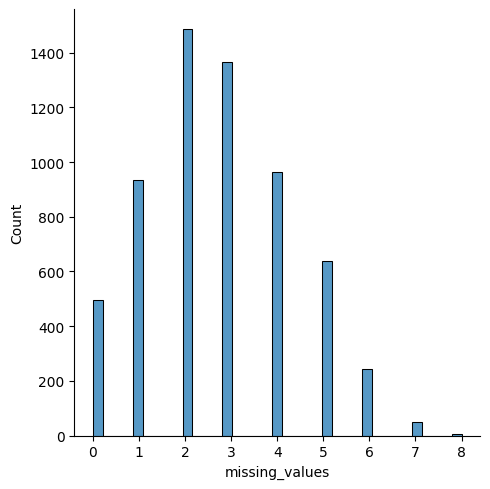

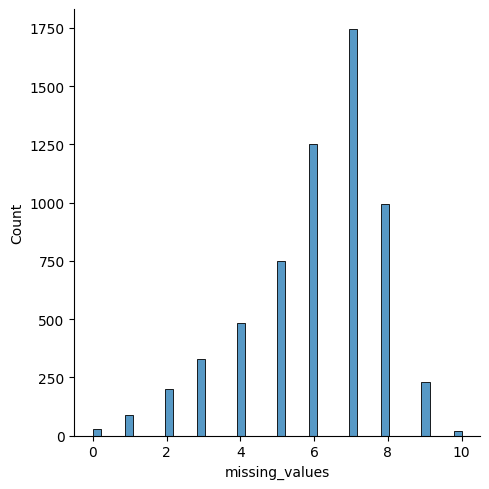

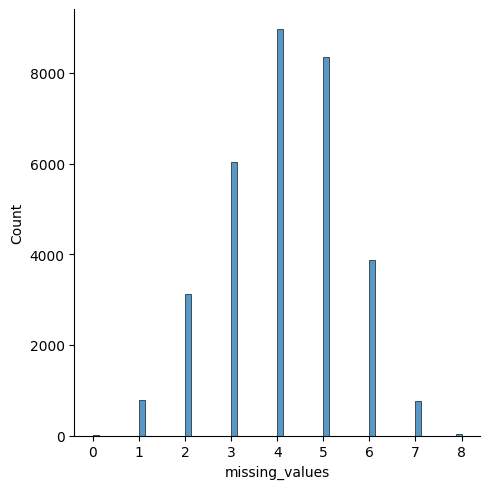

In [167]:
df_past.loc[(df_past["ownerships"].apply(lambda x:True if ((len(x)!=0 and x[0]=="not known") & (len(x)==2 and x[1]=="bootstrapped")) else False)),"ownerships"]="bootstrapped"

bootstraped=df_past.loc[df_past["ownerships"].apply(lambda x: True if x[0]=="bootstrapped" else False),"missing_values"]
not_known=df_past.loc[df_past["ownerships"].apply(lambda x: True if x[0]=="not known" else False),"missing_values"]
subs=df_past.loc[df_past["ownerships"].apply(lambda x: True if x[0]=="Subsidiary" else False),"missing_values"]

sns.displot(subs)
sns.displot(not_known)
sns.displot(bootstraped)



We see that the rows with "not known" as company status have alot of missing values. We will drop them in order to increase the explanatory value of the data

In [168]:
df_past.drop(not_known.index,inplace=True)

Further drop rows that have more missing values for a certain threshold

In [169]:
nothing=df_past.loc[df_past["Y"]==0,"missing_values"].describe()[["mean","std"]]
acquired=df_past.loc[df_past["Y"]=="acquired","missing_values"].describe()[["mean","std"]]
failed=df_past.loc[df_past["Y"]=="failed","missing_values"].describe()[["mean","std"]]
IPO=df_past.loc[df_past["Y"]=="IPO","missing_values"].describe()[["mean","std"]]
funding=df_past.loc[df_past["Y"]=="funding","missing_values"].describe()[["mean","std"]]
missing_df=pd.DataFrame([nothing,acquired,failed,IPO,funding])
missing_df.index=["nothing","acquired","failed","IPO","funding"]
missing_df

,mean,std
nothing,3.848189,1.641936
acquired,2.647092,1.610784
failed,4.155378,1.841861
IPO,2.452486,1.541545
funding,2.898482,1.835271


In [170]:
nothing_index=df_past.loc[(df_past["Y"]==0)&(df_past["missing_values"]>nothing[0]+0.5*nothing[1])].index
acquired_index=df_past.loc[(df_past["Y"]=="acquired")&(df_past["missing_values"]>acquired[0]+1.5*acquired[1])].index
failed_index=df_past.loc[(df_past["Y"]=="failed")&(df_past["missing_values"]>failed[0]+1.2*failed[1])].index
IPO_index=df_past.loc[(df_past["Y"]=="IPO")&(df_past["missing_values"]>IPO[0]+1.5*IPO[1])].index
funding_index=df_past.loc[(df_past["Y"]=="funding")&(df_past["missing_values"]>funding[0]+1.5*IPO[1])].index


In [171]:
df_past.drop(nothing_index,inplace=True)
df_past.drop(acquired_index,inplace=True)
df_past.drop(failed_index,inplace=True)
df_past.drop(IPO_index,inplace=True)
df_past.drop(funding_index,inplace=True)

# Delete all rows that are not desired

In [373]:
df_past2=df_past.drop(columns=["id","tagline","company_status","employees_chart","dealroom_signal","investors_items","team_items","company_status_past","Fin.Round.now","Fin.Round.past","investors_total","fundings_items","team_universities","team_total","investors_total","dealroom_signal","ownerships","cteam"])

## 1. Imputation for Categorical Values where imputation with numerical values doesnt make sense

1. City name 
2. Industry Name (will just drop the rows with empty values, (only 1140))
3. about (drop, only 1401)

1. City Name
- Will use the countries capital if not cities are associated with that country

In [374]:
city_names=pd.read_csv("/Users/klaus/Documents/Jarvis/Second Try/Data/country-list.csv")
city_names.drop(columns="type",inplace=True)

In [375]:
countries=pd.unique(df_past2["country_name"].values)
for i in countries:
    try:
        df_past2.loc[(df_past2["country_name"]==i)&(df_past2["city_name"].apply(lambda p: True if p is not str else False)),"city_name"]=df_past2.loc[df_past2["country_name"]==i,"city_name"].value_counts().idxmax()
    except:
        df_past2.loc[(df_past2["country_name"]==i)&(df_past2["city_name"].apply(lambda p: True if p is not str else False)),"city_name"]=city_names.loc[city_names["country"]==i,"capital"].values[0]

2. Industry Name

In [376]:
industry_index=df_past2.loc[df_past2["industry_name"].isna()].index
df_past2.drop(industry_index,inplace=True)

3. about

In [377]:
about_index=df_past2.loc[df_past2["about"].isna()].index
df_past2.drop(about_index,inplace=True)

See if Imputation has been succesfull

In [469]:
x=df_past2.isna().sum()
y=df_past2.isna().sum()/len(df_past2)*100
missing_values=pd.concat([x, y], axis=1)
missing_values.columns=["Missing Values","In percent"]
print(missing_values)

                    Missing Values  In percent
name                             0    0.000000
about                            0    0.000000
website_url                      0    0.000000
facebook_url                     0    0.000000
twitter_url                      0    0.000000
linkedin_url                     0    0.000000
total_funding                 8339   19.771439
patents_count                    0    0.000000
employees_latest             20765   49.232994
launch_year                      0    0.000000
fundings_total                   0    0.000000
country_name                     0    0.000000
city_name                        0    0.000000
industry_name                    0    0.000000
team_male                        0    0.000000
team_female                      0    0.000000
employees_growth             26577   63.013017
avg_time_funding             29567   70.102188
Y                                0    0.000000
missing_values                   0    0.000000
number_top_sc

In [292]:
df_past2.to_pickle("df_past2_08.11")

In [468]:
df_past2=pd.read_pickle("/Users/klaus/Documents/Jarvis/Second Try/Data/df_past2_08.11")

### Data Transformation

1. About (think about including the language model) (for now we only take the length of "good" words, meaning words except stop words etc)
2. country_name
3. city_name
4. industry_name
5. Y
6. launch_year (make years to now)
7. URL

In [472]:
nltk.download('stopwords')
def tokenizer(x:str):
    stop_words = set(stopwords.words('english'))
    tokens=word_tokenize(x)
    tokens = [w for w in tokens if w not in stop_words]
    return tokens
    

[nltk_data] Downloading package stopwords to /Users/klaus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [476]:
df_past2.head()

,name,about,website_url,facebook_url,twitter_url,linkedin_url,total_funding,patents_count,employees_latest,launch_year,fundings_total,country_name,city_name,industry_name,team_male,team_female,employees_growth,avg_time_funding,Y,missing_values,number_top_schools
0,Sylog Sverige,"[Specialist, consultants, systems, development...",1,0,0,1,NaN,0,139.0,21.0,1,5,2,17,0,0,0.053030,NaN,2,3,1
1,Informed Solutions,"[Informed, Solutions, leading, independent, pr...",1,0,1,1,11400000.0,0,79.0,31.0,1,23,10,11,0,1,0.053351,NaN,2,2,0
2,eCommera,"[Isobar, UK, &, Ireland, team, 400, across, Lo...",1,1,1,0,41000000.0,0,142.0,16.0,5,23,10,6,2,0,-0.117857,1.25,2,1,1
3,Apsmart,"[We, ’, London-based, mobile, innovation, comp...",1,0,1,1,NaN,0,NaN,14.0,4,7,5,12,1,0,NaN,1.00,2,3,0
4,BeatThatQuote.com,"[BeatThatQuote.com, price, comparison, web, si...",1,0,0,1,37700000.0,0,NaN,18.0,1,0,19,16,0,0,NaN,NaN,2,5,0


In [473]:
from nltk.corpus import stopwords

In [474]:
stop_words=set(stopwords.words('english'))

In [477]:
#a=map(lambda p: tokenizer(p), df_past2["about"]) # remove stopwords and seperate str into list of words
#df_past2["about"]=list(a)

a=map(lambda p: len([w.lower() for w in p if w.isalpha()]), df_past2["about"]) # remove all special signs and non alphabetic characters
df_past2["about"]=list(a)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)
about=list(df_past2["about"])
X=vectorizer.fit_transform(about)

In [38]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [51]:
from sklearn.model_selection import train_test_split

In [59]:
X_train, X_test, y_train, y_test  = train_test_split(df_past2["about"], df_past2["Y"], test_size=0.2, random_state=1)

In [64]:
vectors = vectorizer.fit_transform(list(X_train))

# Build the classifier
clf = MultinomialNB(alpha=.01)

#  Train the classifier
clf.fit(vectors, list(y_train))

# Get the test vectors
vectors_test = vectorizer.transform(list(X_test))

# Predict and score the vectors
pred = clf.predict(vectors_test)
acc_score = metrics.accuracy_score(list(y_test), pred)
f1_score = metrics.f1_score(list(y_test), pred, average='macro')

print('Total accuracy classification score: {}'.format(acc_score))
print('Total F1 classification score: {}'.format(f1_score))

Total accuracy classification score: 0.5315315315315315
Total F1 classification score: 0.3335657076966459


array([1])

2. Country_name

In [478]:
le=LabelEncoder()
label=le.fit_transform(df_past2.country_name)

df_past2["country_name"]=label

3. City_name

In [479]:
le=LabelEncoder()
label=le.fit_transform(df_past2.city_name)

df_past2["city_name"]=label

In [ ]:
4. Industry_name

In [480]:
le=LabelEncoder()
label=le.fit_transform(df_past2.industry_name)

df_past2["industry_name"]=label

6. Years

In [481]:
df_past2["launch_year"]=year_dif=2023-df_past2["launch_year"]

7. URL

In [482]:
df_past2["website_url"]=df_past2["website_url"].apply(lambda x:0 if x==None else 1)
df_past2["linkedin_url"]=df_past2["linkedin_url"].apply(lambda x:0 if x==None else 1)
df_past2["facebook_url"]=df_past2["facebook_url"].apply(lambda x:0 if x==None else 1)
df_past2["twitter_url"]=df_past2["twitter_url"].apply(lambda x:0 if x==None else 1)

5. Y
1- nothing happend
2- acquired
3- IPO
4- failed
5- received funding

In [483]:
df_past2.loc[df_past2["Y"]==0,"Y"]=1
df_past2.loc[df_past2["Y"]=="acquired","Y"]=2
df_past2.loc[df_past2["Y"]=="IPO","Y"]=3
df_past2.loc[df_past2["Y"]=="failed","Y"]=4
df_past2.loc[df_past2["Y"]=="funding","Y"]=5

# Imputation

1. total_funding (KNN) - maybe on evertyhing
2. employees latest (median)
3. team_male team_female (distribution)
4. employees_growth (0)
5. avg_time funding (KNN) - total_funding, fundings_total, launch year, country name, 
6. ? number of Schools ?


2. Employees_latest

In [484]:
from sklearn.impute import SimpleImputer
df_mode = df_past2.copy()
mode_imputer = SimpleImputer(strategy='median')
df_mode["employees_latest"] = mode_imputer.fit_transform(df_mode["employees_latest"].values.reshape(-1,1))


3. Team_male Team_female

In [485]:
prob=df_mode["team_female"].sum()/df_mode["team_male"].sum()
df_mode["cteam"]=df_mode["team_male"]+df_mode["team_female"]
df_mode.loc[df_mode["cteam"]!=0,"cteam"]="Set"


In [486]:
shape_df=df_mode.loc[df_mode["cteam"]==0,"cteam"].shape

df_mode.loc[df_mode["cteam"]==0,"cteam"]=np.random.choice(2, shape_df,p=[prob,1-prob])
df_mode.loc[df_mode["cteam"]==1,"team_male"]=1
df_mode.loc[df_mode["cteam"]==0,"team_female"]=1

4. Employees_Growth

In [487]:
df_mode.loc[df_mode["employees_growth"].apply(lambda x: True if math.isnan(x) else False),"employees_growth"]=0

5. avg_time funding

In [488]:
df_mode.head()

,name,about,website_url,facebook_url,twitter_url,linkedin_url,total_funding,patents_count,employees_latest,launch_year,fundings_total,country_name,city_name,industry_name,team_male,team_female,employees_growth,avg_time_funding,Y,missing_values,number_top_schools,cteam
0,Sylog Sverige,114,1,1,1,1,NaN,0,139.0,2002.0,1,5,2,17,1,0,0.053030,NaN,2,3,1,1
1,Informed Solutions,167,1,1,1,1,11400000.0,0,79.0,1992.0,1,23,10,11,0,1,0.053351,NaN,2,2,0,Set
2,eCommera,73,1,1,1,1,41000000.0,0,142.0,2007.0,5,23,10,6,2,0,-0.117857,1.25,2,1,1,Set
3,Apsmart,101,1,1,1,1,NaN,0,47.0,2009.0,4,7,5,12,1,0,0.000000,1.00,2,3,0,Set
4,BeatThatQuote.com,34,1,1,1,1,37700000.0,0,47.0,2005.0,1,0,19,16,1,0,0.000000,NaN,2,5,0,1


Total funding / avg funding time

In [489]:
df_mode.loc[df_mode["fundings_total"].apply(lambda x: True if type(x) is not int else False),"fundings_total"]=0

In [504]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

df_mice = df_mode.filter(['total_funding', 'fundings_total', 'launch_year', 'country_name',"avg_time_funding","employees_latest","launch_year","number_top_schools"], axis=1)
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending',missing_values=np.nan)
df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)

In [523]:
df_mode["total_funding"]=df_mice_imputed["total_funding"].values
df_mode["avg_time_funding"]=df_mice_imputed["avg_time_funding"].values
df_mode.drop(df_mode.loc[df_mode["name"].isna()].index,inplace=True)


In [537]:
x=df_mode.isna().sum()
y=df_mode.isna().sum()/len(df_mode)*100
missing_values=pd.concat([x, y], axis=1)
missing_values.columns=["Missing Values","In percent"]
print(missing_values)

                      Missing Values  In percent
name                               0         0.0
about                              0         0.0
website_url                        0         0.0
facebook_url                       0         0.0
twitter_url                        0         0.0
linkedin_url                       0         0.0
total_funding                      0         0.0
patents_count                      0         0.0
employees_latest                   0         0.0
launch_year                        0         0.0
fundings_total                     0         0.0
country_name                       0         0.0
city_name                          0         0.0
industry_name                      0         0.0
team_male                          0         0.0
team_female                        0         0.0
employees_growth                   0         0.0
avg_time_funding                   0         0.0
Y                                  0         0.0
missing_values      

In [540]:
df_past2.to_pickle("df_past2_09.11")
df_mode.to_pickle("df_mode_09.11")

In [541]:
df_mode.shape

(42177, 24)

### Data Balancing

Two Approaches will be applied, SMOTE and deleting rows from underrepresented Classes

In [539]:
from imblearn.over_sampling import SMOTE

ModuleNotFoundError: No module named 'imblearn'